Init weights for DenseLayer XOR_2->3 (shape (3, 2))
Init biases shape for DenseLayer XOR_2->3 (shape (3, 1))
Init weights for DenseLayer XOR_3->1 (shape (1, 3))
Init biases shape for DenseLayer XOR_3->1 (shape (1, 1))


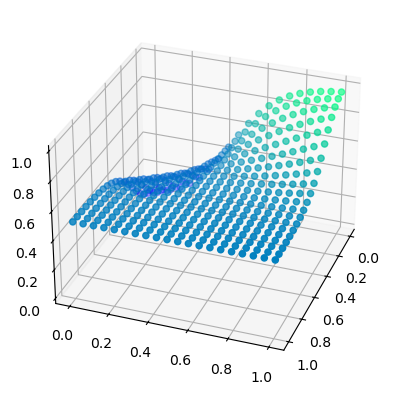

Init weights for DenseLayer MNIST_784->100 (shape (100, 784))
Init biases shape for DenseLayer MNIST_784->100 (shape (100, 1))
Init weights for DenseLayer MNIST_100->50 (shape (50, 100))
Init biases shape for DenseLayer MNIST_100->50 (shape (50, 1))
Init weights for DenseLayer MNIST_50->10 (shape (10, 50))
Init biases shape for DenseLayer MNIST_50->10 (shape (10, 1))
1/100, error=0.10051491665750752
2/100, error=0.0945669040757433
3/100, error=0.08634370383500281
4/100, error=0.07854169626515745
5/100, error=0.07089573242495592
6/100, error=0.06319813148527098
7/100, error=0.056681090771132564
8/100, error=0.05097208104112813
9/100, error=0.046370513495133284
10/100, error=0.0429905423902642
11/100, error=0.040451145871066053
12/100, error=0.03844538066067945
13/100, error=0.03679060713334563
14/100, error=0.0353877317438992
15/100, error=0.034168287456845976
16/100, error=0.03308390977644624
17/100, error=0.03210300255981868
18/100, error=0.031206492048669935
19/100, error=0.030383133

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from keras.utils import to_categorical
from sklearn.metrics import confusion_matrix

WEIGHTS_FILENAME="07_MNIST_manual_weights_{}.npy"
BIASES_FILENAME="07_MNIST_manual_bias_{}.npy"

class DenseLayer:
    def __init__(self, identifier, input_size, output_size):
        self.identifier = identifier
        self.v_weights = 0.0
        self.v_bias = 0.0

        if os.path.exists(WEIGHTS_FILENAME.format(identifier)):
            self.weights = np.load(WEIGHTS_FILENAME.format(identifier))
            print("Loaded weights for DenseLayer {} (shape: {})".format(identifier, self.weights.shape))
        else:
            self.weights = np.random.randn(output_size, input_size)
            print("Init weights for DenseLayer {} (shape {})".format(identifier, self.weights.shape))
        
        if os.path.exists(BIASES_FILENAME.format(identifier)):
            self.bias = np.load(BIASES_FILENAME.format(identifier))
            print("Loaded biases for DenseLayer {} (shape {})".format(identifier, self.bias.shape))
        else:
            self.bias = np.random.randn(output_size, 1)
            print("Init biases shape for DenseLayer {} (shape {})".format(identifier, self.bias.shape))

    def save(self):
        np.save(WEIGHTS_FILENAME.format(self.identifier), self.weights)
        np.save(BIASES_FILENAME.format(self.identifier), self.bias)

    def forward(self, input_data):
        self.input = input_data
        return np.dot(self.weights, input_data) + self.bias

    def backward(self, output_gradient, learning_rate, momentum):
        weights_gradient = np.dot(output_gradient, self.input.T)
        input_gradient = np.dot(self.weights.T, output_gradient)

        if (momentum == False):
            self.weights = self.weights - learning_rate * weights_gradient
            self.bias = self.bias - learning_rate * output_gradient
        else:
            self.v_weights = momentum * self.v_weights - learning_rate * weights_gradient
            self.weights += self.v_weights
            self.v_bias = momentum * self.v_bias - learning_rate * output_gradient
            self.bias += self.v_bias
 
        return input_gradient

class ActivationLayer:
    def __init__(self, activation, activation_prime):
        self.activation = activation
        self.activation_prime = activation_prime

    def save(self):
        pass

    def forward(self, input_data):
        self.input = input_data
        return self.activation(input_data)

    def backward(self, output_gradient, learning_rate, momentum):
        return np.multiply(output_gradient, self.activation_prime(self.input))

class TanhActivation(ActivationLayer):
    def __init__(self):
        def tanh(x):
            return np.tanh(x)

        def tanh_prime(x):
            return 1 - np.tanh(x) ** 2

        super().__init__(tanh, tanh_prime)

class SigmoidActivation(ActivationLayer):
    def __init__(self):
        def sigmoid(x):
            return 1 / (1 + np.exp(-x))

        def sigmoid_prime(x):
            s = sigmoid(x)
            return s * (1 - s)

        super().__init__(sigmoid, sigmoid_prime)

def mse(y_true, y_pred):
    return np.mean(np.power(y_true - y_pred, 2))

def mse_prime(y_true, y_pred):
    return 2 * (y_pred - y_true) / np.size(y_true)

def binary_cross_entropy(y_true, y_pred):
    return np.mean(-y_true * np.log(y_pred) - (1 - y_true) * np.log(1 - y_pred))

def binary_cross_entropy_prime(y_true, y_pred):
    return ((1 - y_true) / (1 - y_pred) - y_true / y_pred) / np.size(y_true)


def predict(network, input_data):
    output = input_data
    for layer in network:
        output = layer.forward(output)
    return output

def train(network, loss, loss_prime, x_train, y_train, epochs = 1000, learning_rate = 1e-1, momentum = False, save = True, verbose = False):
    for e in range(epochs):
        error = 0
        for x, y in zip(x_train, y_train):
            # forward
            output = predict(network, x)

            # error
            error += loss(y, output)

            # backward
            grad = loss_prime(y, output)
            for layer in reversed(network):
                grad = layer.backward(grad, learning_rate, momentum)

        error /= len(x_train)
        if verbose:
            print(f"{e + 1}/{epochs}, error={error}")

    if save:
          for layer in network:
              layer.save()

def test(network, input_data):
    results = []
    for i in range(input_data.shape[0]):
        output = input_data[i]
        for layer in network:
            output = layer.forward(output)
        results.append(output)
    return results

# 1. XOR verification
X = np.reshape([[0, 0], [0, 1], [1, 0], [1, 1]], (4, 2, 1))
Y = np.reshape([[0], [1], [1], [0]], (4, 1, 1))

xor_network = [
    DenseLayer("XOR_2->3", 2, 3),
    SigmoidActivation(),
    # TanhActivation(),
    DenseLayer("XOR_3->1", 3, 1),
    SigmoidActivation(),
    # TanhActivation(),
]

train(xor_network, mse, mse_prime, X, Y, epochs=10000, learning_rate=1e-2, momentum=9e-1, save=False, verbose=False)

points = []
for x in np.linspace(0, 1, 20):
    for y in np.linspace(0, 1, 20):
        z = predict(xor_network, [[x], [y]])
        points.append([x, y, z[0,0]])

points = np.array(points)

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.view_init(30,20)
ax.scatter(points[:, 0], points[:, 1], points[:, 2], c=points[:, 2], cmap="winter")
plt.show()

# 2. MNIST challenge
xtrn = np.load("mnist_train_images.npy")
ytrn = np.load("mnist_train_labels.npy")
xtst = np.load("mnist_test_images.npy")
ytst = np.load("mnist_test_labels.npy")

def preprocess_data(x, y, limit):
    # reshape and normalize input data
    x = x.reshape(x.shape[0], 28 * 28, 1)
    x = x.astype("float32") / 255
    # encode output which is a number in range [0,9] into a vector of size 10
    # e.g. number 3 will become [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
    y = to_categorical(y)
    y = y.reshape(y.shape[0], 10, 1)
    # shuffle
    idx = np.argsort(np.random.random(y.shape[0]))
    x = x[idx]
    y = y[idx]
    # return limited amount
    return x[:limit], y[:limit]

xtrn, ytrn = preprocess_data(xtrn, ytrn, 6000)
xtst, ytst = preprocess_data(xtst, ytst, 300)

network = [
    DenseLayer("MNIST_784->100", 28 * 28, 100),
    SigmoidActivation(),
    # TanhActivation(),
    DenseLayer("MNIST_100->50", 100, 50),
    SigmoidActivation(),
    # TanhActivation(),
    DenseLayer("MNIST_50->10", 50, 10),
    SigmoidActivation(),
    # TanhActivation(),
]

train(network, mse, mse_prime, xtrn, ytrn, epochs=100, learning_rate=1e-2, momentum=9e-1, save=True, verbose=True)

out = test(network, xtst)
cm = confusion_matrix([np.argmax(y_true) for y_true in ytst], [np.argmax(y_pred) for y_pred in out])

print()
print(np.array2string(cm))
print()
print("accuracy = %0.7f" % (np.diag(cm).sum() / cm.sum()))